In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

data ; crop and resize  
network ; xception , decrease batch_size. 

ImageAugment  ; shift add. 
random_eraser ; image part remove

batch 32
earlystop ; f1_score 
checkpoint best save 

train acc;  , val acc;  , lb acc;   
model1 ;  96, 84
model2;  96, 85
model3 ; 95, 86

enssamble. sum.

## Data Processing

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
from PIL import Image
import seaborn as sns

Using TensorFlow backend.


In [2]:
basedir='/kaggle/input/'

In [3]:
# 클래스 데이터 읽기  
dfclass = pd.read_csv(basedir+'class.csv')
dftest = pd.read_csv(basedir+'test.csv')

# 훈련 데이터 읽기  
dftrain = pd.read_csv(basedir+'train.csv')
dftrain.head()
dftrain['class']=dftrain['class']-1  # make class [0,195] from [1,196]
dftrain.describe()
# shape 형상, 개수 확인   
dftrain.shape, dftest.shape, dfclass.shape

((9990, 6), (6150, 5), (196, 2))

In [4]:
# 이미지를 바인딩 박스만 추출하여 리사이즈 한다. (차만 보이게 추출하고 리사이즈)
''' crop and resize '''
def prepro_img(imgpath, bb):
    img = Image.open(imgpath)
    img = img.convert('RGB')  # 3 channel image.
#     img = img.convert('L')  # 1 channel gray scale -image.
    imgn = np.asarray(img)
    imgc = imgn[bb[1]:bb[3], bb[0]:bb[2]]
#     print(imgc.shape)
    imgcobj = Image.fromarray(imgc)
    imgcobj2 = imgcobj.resize((224,224))
    newimg = np.asarray(imgcobj2)
    return newimg

(224, 224, 3)


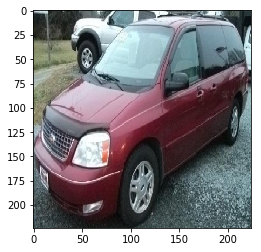

In [5]:
# preprocess test
i=0
imgpath = basedir+'train/'+dftrain.loc[i]['img_file']
bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
cl = dftrain.loc[i]['class']
img = prepro_img(imgpath, bb)
print(img.shape)
plt.imshow(img, cmap='gray')

## Make Train dataset

In [7]:
# 훈련 데이터 만들기. 
#      주의! class값 범위는 0~195로 조정하여 저장. 실제 클래스값(1~196)을 알려면 +1 필요.
# crop and resize하여 저장
# make train data numpy 

force = True

cnt_train = dftrain.shape[0]
x_train=[]
y_train=[]

if not os.path.exists('x_train.npy') or force :
    for i in range(cnt_train):
    # for i in range(100):
        if i%1000==0 :
            print(i, '/', cnt_train)
        imgpath = basedir+'train/'+dftrain.loc[i]['img_file']
        bb = [dftrain.loc[i]['bbox_x1'], dftrain.loc[i]['bbox_y1'], dftrain.loc[i]['bbox_x2'], dftrain.loc[i]['bbox_y2']]
        cl = dftrain.loc[i]['class']
        y_train.append(cl)
        test1 = prepro_img(imgpath, bb)
    #     print(test1.shape)
        x_train.append(test1)
    #     plt.figure()
    #     plt.imshow(test1)
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    ### shuffle
    idx = np.arange(len(x_train))
    np.random.shuffle(idx)
    x_train = x_train[idx]
    y_train = y_train[idx]    
    
    print(x_train.shape, y_train.shape)
    np.save('x_train.npy', x_train)
    np.save('y_train.npy', y_train)
else:
    print('x_train.npy already exsits!')
    
# 테스트 데이터도 전처리하여 저장한다.
# make test data numpy 
cnt_test = dftest.shape[0]
x_test=[]
if not os.path.exists('x_test.npy') or force:
    for i in range(cnt_test):
        if i%1000==0 :
            print(i, '/', cnt_test)
        imgpath = basedir+'test/'+dftest.loc[i]['img_file']
        bb = [dftest.loc[i]['bbox_x1'], dftest.loc[i]['bbox_y1'], dftest.loc[i]['bbox_x2'], dftest.loc[i]['bbox_y2']]
        test1 = prepro_img(imgpath, bb)
        x_test.append(test1)
    x_test = np.asarray(x_test)
    print(x_test.shape)
    np.save('x_test.npy', x_test)
else:
    print('x_test.npy already exsits!')    
    
# release memory 
del dftrain
del dftest
del dfclass
del x_train
del y_train
del x_test    

0 / 9990
1000 / 9990
2000 / 9990
3000 / 9990
4000 / 9990
5000 / 9990
6000 / 9990
7000 / 9990
8000 / 9990
9000 / 9990
(9990, 224, 224, 3) (9990,)
0 / 6150
1000 / 6150
2000 / 6150
3000 / 6150
4000 / 6150
5000 / 6150
6000 / 6150
(6150, 224, 224, 3)


## load package

In [8]:
import sys
import pandas as pd

from keras.applications import xception
from keras.preprocessing import image
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Softmax
import random
from keras.utils import np_utils
from keras.models import load_model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, K
from keras.models import Input, Model
from sklearn.metrics import f1_score

from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [14]:
cache=False
basedir = '/kaggle/input/'
imgwidth=224
imgheight=224
get_ipython().run_line_magic('matplotlib', 'inline')

# K fold
fold_k = 5
# current fold
fold_c = 5   # 1~fold_k

## TRAIN

In [18]:
x_trainall = np.load('x_train.npy')
y_trainall = np.load('y_train.npy')
dfclass = pd.read_csv(basedir+'class.csv')

In [19]:
# cross validation
datacnt = x_trainall.shape[0]
flagval = np.zeros(datacnt)
modelpath = 'car-v4-'+str(fold_c)+'.ckpt'

print('modelpath=', modelpath)
flagval[(fold_c-1)*2000:(fold_c)*2000] = 1

x_train = x_trainall[flagval==0]
y_train = y_trainall[flagval==0]
x_val = x_trainall[flagval==1]
y_val = y_trainall[flagval==1]
    
del x_trainall
del y_trainall
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
print(np.min(y_train), np.max(y_train))
y_train_onehot = np_utils.to_categorical(y_train, 196)
y_val_onehot = np_utils.to_categorical(y_val, 196)

modelpath= car-v4-5.ckpt
(8000, 224, 224, 3) (8000,) (1990, 224, 224, 3) (1990,)
0 195


In [20]:
#ref: https://github.com/yu4u/cutout-random-erasing/blob/master/cifar10_resnet.py
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()
        if p_1 > p:
            return input_img
        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)
            if left + w <= img_w and top + h <= img_h:
                break
        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c
        return input_img
    return eraser

In [21]:
# Image Augumentation
batch_size=32  # 32, 64
datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=False, 
                              width_shift_range=0.1, height_shift_range=0.1,
                              fill_mode='nearest', preprocessing_function = get_random_eraser(v_l=0, v_h=1),)
datagen2 = ImageDataGenerator(rescale=1./255)
train_generator = datagen1.flow(x_train, y_train_onehot, batch_size=batch_size)
val_generator = datagen2.flow(x_val, y_val_onehot, batch_size=batch_size, shuffle=False)

In [22]:
# f1 score 
def new_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
### checkpoint save weights in progress...
cp_callback = ModelCheckpoint(modelpath,  monitor='val_new_score', mode='max', save_best_only=True, save_weights_only=True)
es_callback = EarlyStopping(monitor='val_new_score',  mode='max', patience=20, min_delta=0.0001)

# tensorboard log
if not os.path.exists('log'):
    os.mkdir('log')
tensorboard = TensorBoard(log_dir='log/'+str(time.time()))

In [24]:
inputs = Input(shape=(224,224,3))
net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='max')
net2 = Dense(224, activation='relu') (net.layers[-1].output)
net2 = Dense(196)(net2)
net2 = Softmax(196)(net2)
model = Model(inputs=inputs, outputs=net2)
# model.summary()

83689472/83683744 [==============================] - 7s 0us/step


In [26]:
##### model freeze. after acc 90.
if False:
    print('freezing...')
    for layer in model.layers[:-4]:
        layer.trainable=False
else:
    print('no freezing...')
#     for layer in model.layers:
#         print(layer, layer.trainable)
#     model.summary()

no freezing...


In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', new_score])

In [28]:
if os.path.exists(modelpath):
    print('load weights...')
    model.load_weights(modelpath)
else:
    print('not found weights... new')

not found weights... new


In [ ]:
# epochs = 100
hist = model.fit_generator( train_generator, initial_epoch=0, epochs = 500, validation_data=val_generator, 
                           callbacks=[tensorboard, cp_callback, es_callback],
                           steps_per_epoch=len(x_train)/batch_size, validation_steps=len(x_val)/batch_size)

Epoch 1/500
250/250 [==============================] - 121s 486ms/step - loss: 5.2320 - acc: 0.0066 - new_score: 6.2500e-09 - val_loss: 5.9184 - val_acc: 0.0065 - val_new_score: 6.3317e-09
Epoch 2/500
250/250 [==============================] - 109s 437ms/step - loss: 4.9129 - acc: 0.0125 - new_score: 6.2500e-09 - val_loss: 5.5322 - val_acc: 0.0095 - val_new_score: 6.2296e-09
Epoch 3/500
250/250 [==============================] - 109s 436ms/step - loss: 4.5038 - acc: 0.0243 - new_score: 6.2500e-09 - val_loss: 5.1209 - val_acc: 0.0111 - val_new_score: 9.7457e-04
Epoch 4/500
250/250 [==============================] - 109s 437ms/step - loss: 4.1620 - acc: 0.0404 - new_score: 4.8485e-04 - val_loss: 4.2639 - val_acc: 0.0467 - val_new_score: 9.7458e-04
Epoch 5/500
250/250 [==============================] - 109s 436ms/step - loss: 3.7335 - acc: 0.0771 - new_score: 0.0036 - val_loss: 4.1106 - val_acc: 0.0588 - val_new_score: 0.0103
Epoch 6/500
250/250 [==============================] - 109s 437

## Submission

In [ ]:
# test data load for submission
x_test = np.load('x_test.npy')
x_test = x_test/255.

In [ ]:
# ensamble. submission.
# model = load_mode('car-v4.h5')
if True:
#     mo = load_model(mp, custom_objects={'new_score': new_score})
    inputs = Input(shape=(224,224,3))
    net = xception.Xception(input_tensor=inputs, input_shape=(224, 224, 3), include_top=False, pooling='max')
    net2 = Dense(224, activation='relu') (net.layers[-1].output)
    net2 = Dense(196)(net2)
    net2 = Softmax(196)(net2)
    model = Model(inputs=inputs, outputs=net2)
    predictions=[]
    for ff in range(1, fold_k+1):
        mp='car-v4-'+str(ff)+'.ckpt'
        print('model',ff,':', mp)
        model.load_weights(mp)
        pr = model.predict( x_test )
        predictions.append(pr)
        print('prediction',ff,':',pr)
    predictions = np.asarray(predictions)
    prk = np.sum(predictions, axis=0 )
    pdi = np.argmax(prk, axis=1)
    print('final:', pdi, np.min(pdi), np.max(pdi))

In [ ]:
submission = pd.read_csv(basedir+'sample_submission.csv')
submission["class"] = pdi + 1  # class [0,195] to [1,196]  
submission.to_csv("submission.csv", index=False)
submission.head()
sns.countplot(submission["class"], order=submission["class"].value_counts(ascending=True).index)